# DUET Stage 1-3 Diagnostics Notebook

This notebook provides comprehensive diagnostics for the DUET model:

1. **FFT Split Visualization** - Original, I_low, I_high, gradient magnitude maps
2. **Stage 2 Edge Alignment** - Edge alignment score with GT boundary
3. **Stage 3 Fusion Interpretability** - π_H, π_L heatmaps and correctness correlation
4. **Uncertainty-as-Error Detector** - AUROC/AUPR and risk-coverage curves
5. **Stage 1 Probes** - Domain classifier and boundary probes (optional)

All plots are reproducible (fixed seeds) and saved to `outputs/diagnostics/`.


## 0. Setup and Imports


In [1]:
import os
import sys
from pathlib import Path
from datetime import datetime

# Add project root to path
PROJECT_ROOT = Path('.').absolute().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Output directory with timestamp
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_DIR = Path(f'../outputs/diagnostics/{TIMESTAMP}')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f'Output directory: {OUTPUT_DIR.absolute()}')

# Matplotlib settings
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'


/opt/homebrew/Caskroom/mambaforge/base/envs/duet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Output directory: /Users/minhnguyen/Desktop/DUET/notebooks/../outputs/diagnostics/20260108_233017


In [2]:
# Import DUET modules
try:
    from src.models.freq.fft_split_adaptive import FFTSplitAdaptive, FFTSplitAdaptiveConfig
    from src.models.fusion.evidence_fusion_v2 import EvidenceFusionV2, EvidenceFusionV2Config
    from src.models.losses.weighted_focal_iou import compute_boundary_weights, WeightedLossConfig
    from src.models.viz.frequency_viz import (
        plot_fft_split_single, plot_energy_curve, plot_gradient_comparison,
        plot_fusion_weights, plot_uncertainty_heatmap,
        compute_gradient_magnitude, tensor_to_numpy, normalize_for_display
    )
    print('DUET modules imported successfully!')
except ImportError as e:
    print(f'Import error: {e}')
    print('Make sure you are running from the notebooks/ directory')


DUET modules imported successfully!


## 1. Load Sample Data

Load a small batch of sample images for diagnostics.


In [3]:
from PIL import Image
from glob import glob

DATA_ROOT = Path('../data')

def load_image(path: Path, size: int = 256) -> torch.Tensor:
    """Load and preprocess image."""
    img = Image.open(path).convert('RGB')
    img = img.resize((size, size), Image.BILINEAR)
    arr = np.array(img).astype(np.float32) / 255.0
    return torch.from_numpy(arr).permute(2, 0, 1)  # (C, H, W)

def load_mask(path: Path, size: int = 256) -> torch.Tensor:
    """Load and preprocess mask."""
    mask = Image.open(path).convert('L')
    mask = mask.resize((size, size), Image.NEAREST)
    arr = np.array(mask).astype(np.float32) / 255.0
    return torch.from_numpy(arr).unsqueeze(0)  # (1, H, W)

# Find sample images from 5_benchmark test datasets
sample_images = []
sample_masks = []
sample_names = []

for dataset in ['CVC-300', 'CVC-ClinicDB', 'Kvasir', 'ETIS-LaribPolypDB']:
    img_dir = DATA_ROOT / '5_benchmark' / 'TestDataset' / dataset / 'images'
    mask_dir = DATA_ROOT / '5_benchmark' / 'TestDataset' / dataset / 'masks'
    
    if img_dir.exists():
        imgs = sorted(img_dir.glob('*'))[:2]  # Take 2 samples per dataset
        for img_path in imgs:
            mask_path = mask_dir / img_path.name
            if mask_path.exists():
                sample_images.append(load_image(img_path))
                sample_masks.append(load_mask(mask_path))
                sample_names.append(f"{dataset}/{img_path.stem}")

if sample_images:
    images = torch.stack(sample_images)  # (N, 3, H, W)
    masks = torch.stack(sample_masks)    # (N, 1, H, W)
    print(f'Loaded {len(images)} sample images from 5_benchmark')
else:
    # Create synthetic data if real data not available
    print('Creating synthetic sample data...')
    images = torch.rand(4, 3, 256, 256)
    masks = (torch.rand(4, 1, 256, 256) > 0.7).float()
    sample_names = [f'synthetic_{i}' for i in range(4)]

print(f'Images shape: {images.shape}')
print(f'Masks shape: {masks.shape}')


Loaded 8 sample images from 5_benchmark
Images shape: torch.Size([8, 3, 256, 256])
Masks shape: torch.Size([8, 1, 256, 256])


## 2. FFT Split Visualization (Goal A3)

For each sample image:
- Plot original, I_low, I_high, and their gradient magnitude maps
- Plot chosen D0 radius and energy curve E(r)/E_tot vs r


In [4]:
# Initialize adaptive FFT split
fft_cfg = FFTSplitAdaptiveConfig(
    p_default=0.95,
    auto_edge_adjust=False,
    log_cutoff=True
)
fft_split = FFTSplitAdaptive(fft_cfg)

# Run FFT split
with torch.no_grad():
    fft_out = fft_split(images, return_masks=True)
    diag_info = fft_split.get_diagnostic_info(images)

print(f'D0 radii: {fft_out.d0_radii.numpy()}')


D0 radii: [0.025 0.025 0.025 0.045 0.025 0.015 0.015 0.015]


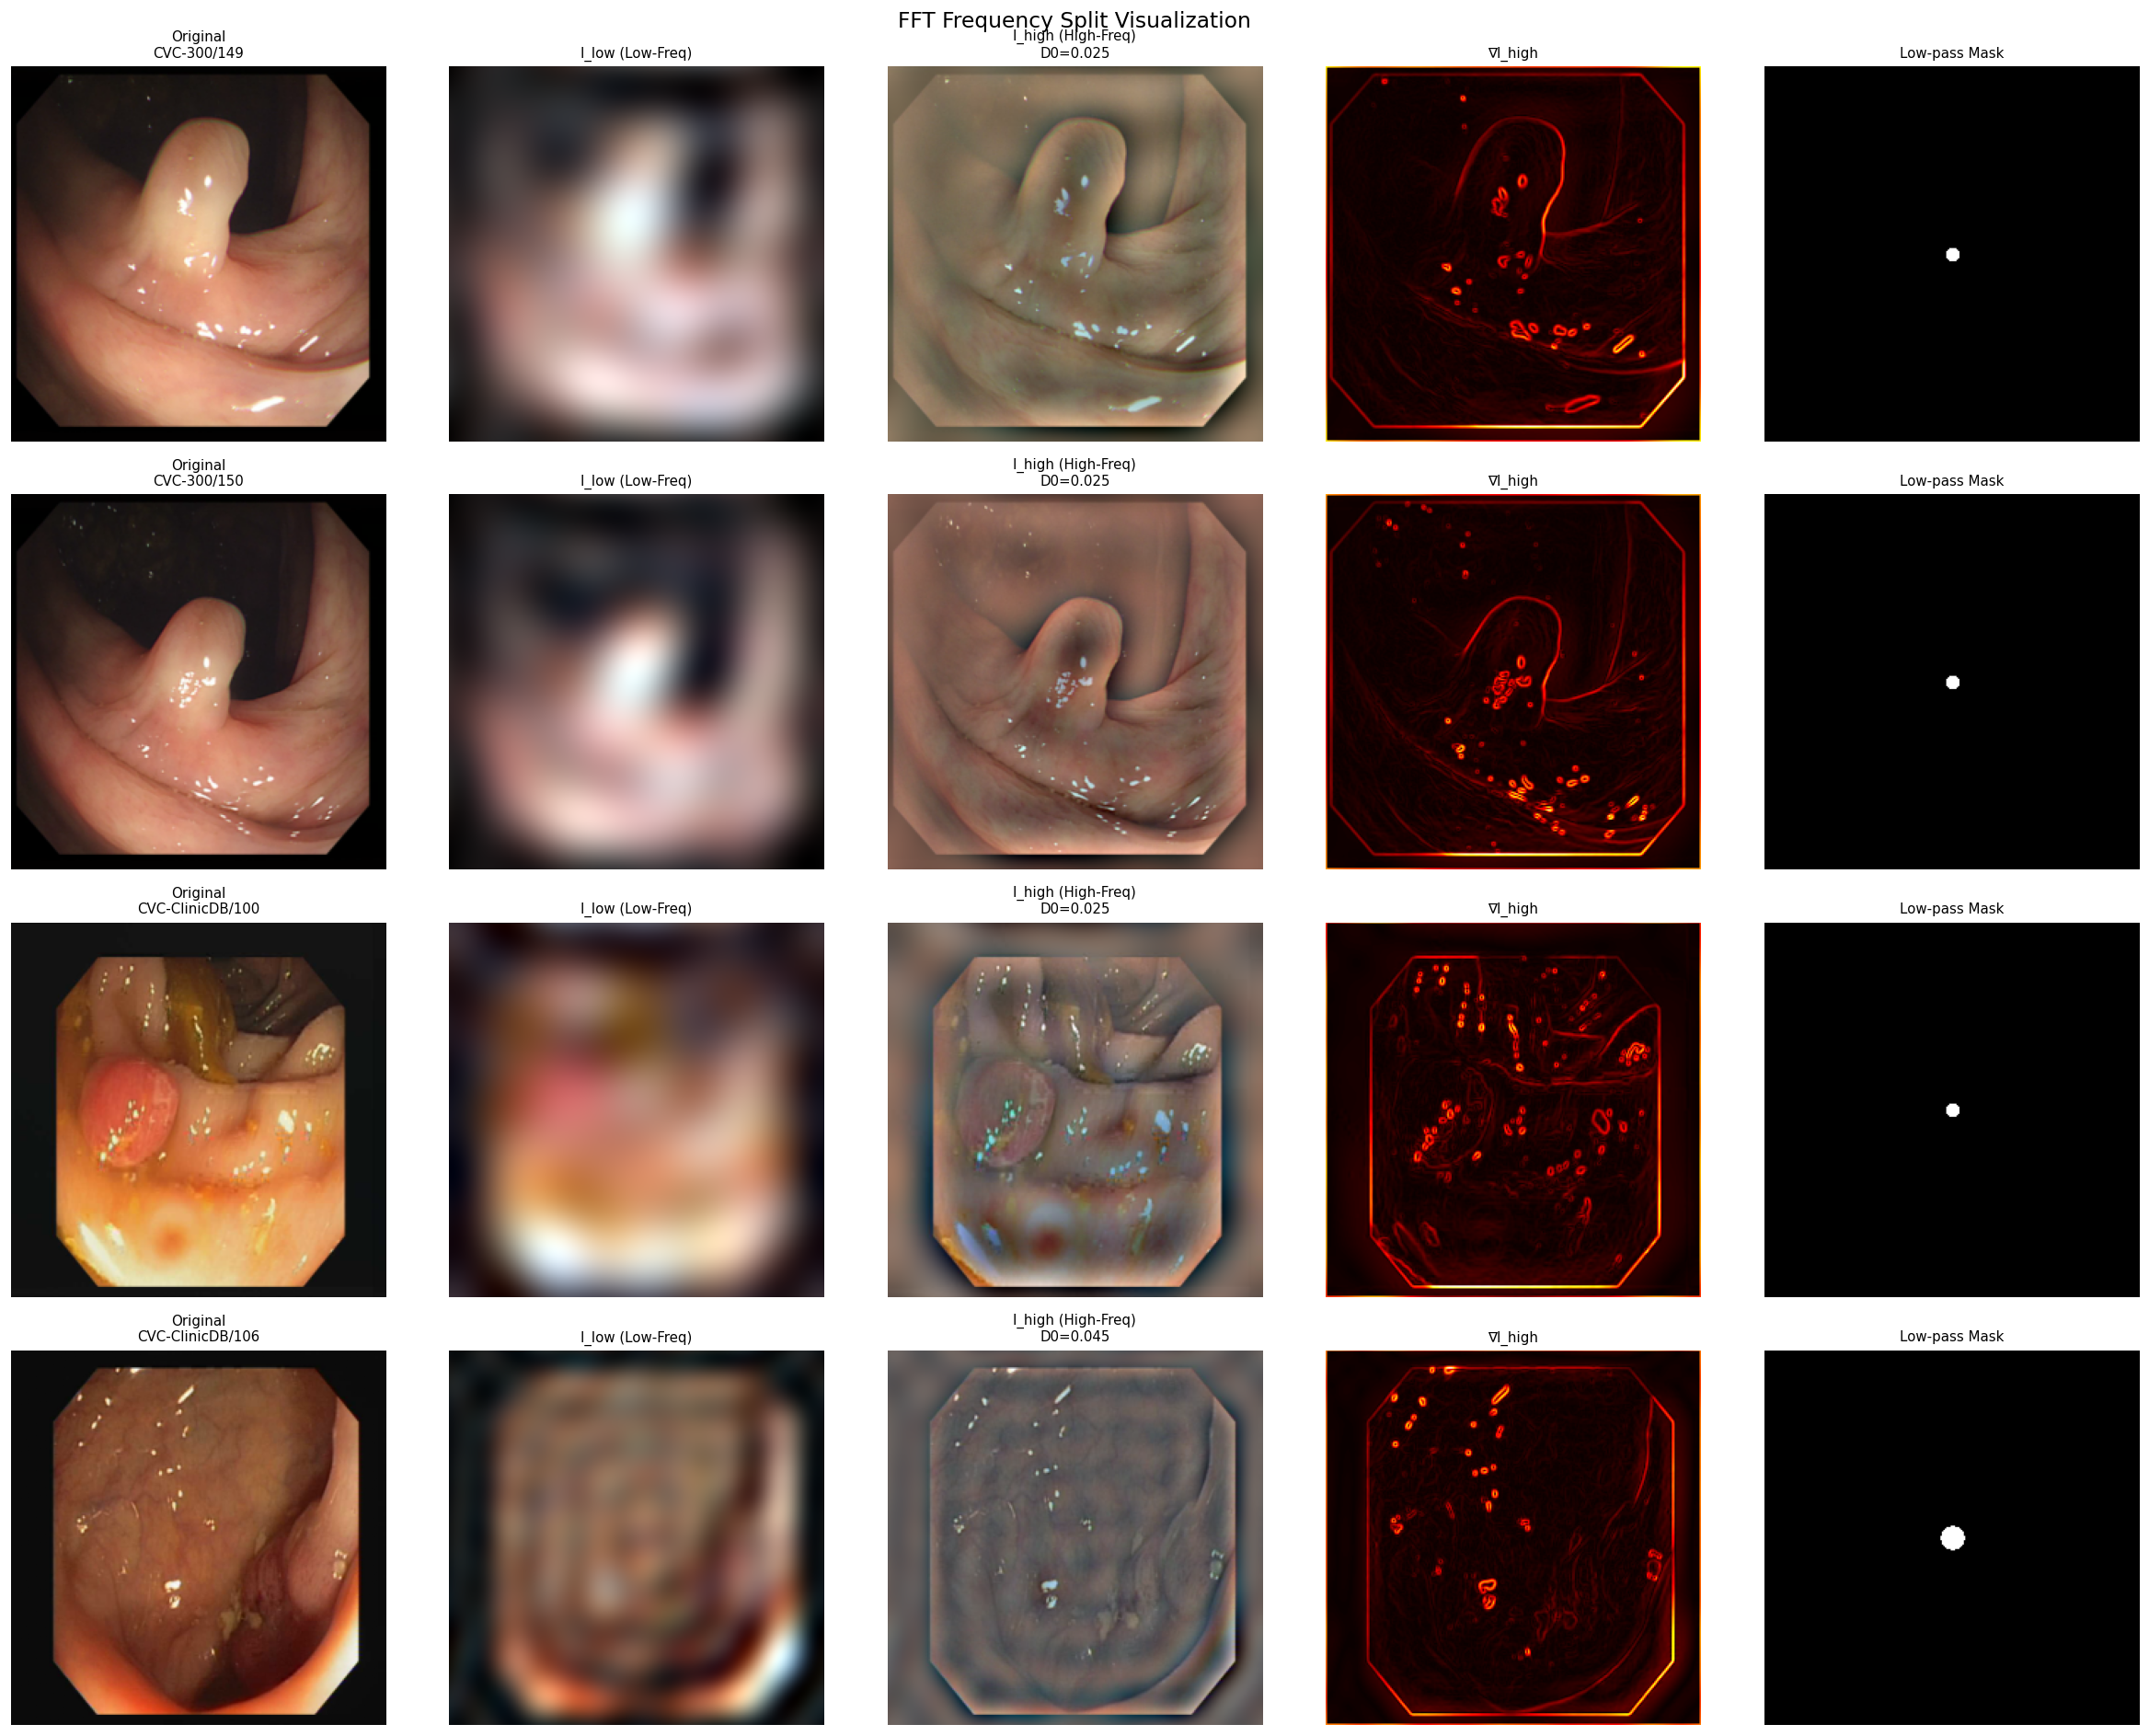

In [5]:
# Plot FFT split for each image
n_samples = min(4, len(images))

fig, axes = plt.subplots(n_samples, 5, figsize=(20, 4 * n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

for i in range(n_samples):
    # Original
    axes[i, 0].imshow(normalize_for_display(tensor_to_numpy(images[i:i+1])[0]))
    axes[i, 0].set_title(f'Original\n{sample_names[i]}', fontsize=9)
    axes[i, 0].axis('off')
    
    # I_low
    axes[i, 1].imshow(normalize_for_display(tensor_to_numpy(fft_out.i_low[i:i+1])[0]))
    axes[i, 1].set_title('I_low (Low-Freq)', fontsize=9)
    axes[i, 1].axis('off')
    
    # I_high
    axes[i, 2].imshow(normalize_for_display(tensor_to_numpy(fft_out.i_high[i:i+1])[0]))
    axes[i, 2].set_title(f'I_high (High-Freq)\nD0={fft_out.d0_radii[i]:.3f}', fontsize=9)
    axes[i, 2].axis('off')
    
    # Gradient of I_high
    grad_high = compute_gradient_magnitude(fft_out.i_high[i:i+1])
    axes[i, 3].imshow(tensor_to_numpy(grad_high)[0, :, :, 0], cmap='hot')
    axes[i, 3].set_title('∇I_high', fontsize=9)
    axes[i, 3].axis('off')
    
    # Frequency mask
    axes[i, 4].imshow(tensor_to_numpy(fft_out.mask_low[i:i+1])[0, :, :, 0], cmap='gray')
    axes[i, 4].set_title('Low-pass Mask', fontsize=9)
    axes[i, 4].axis('off')

plt.suptitle('FFT Frequency Split Visualization', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fft_split_visualization.png')
plt.show()


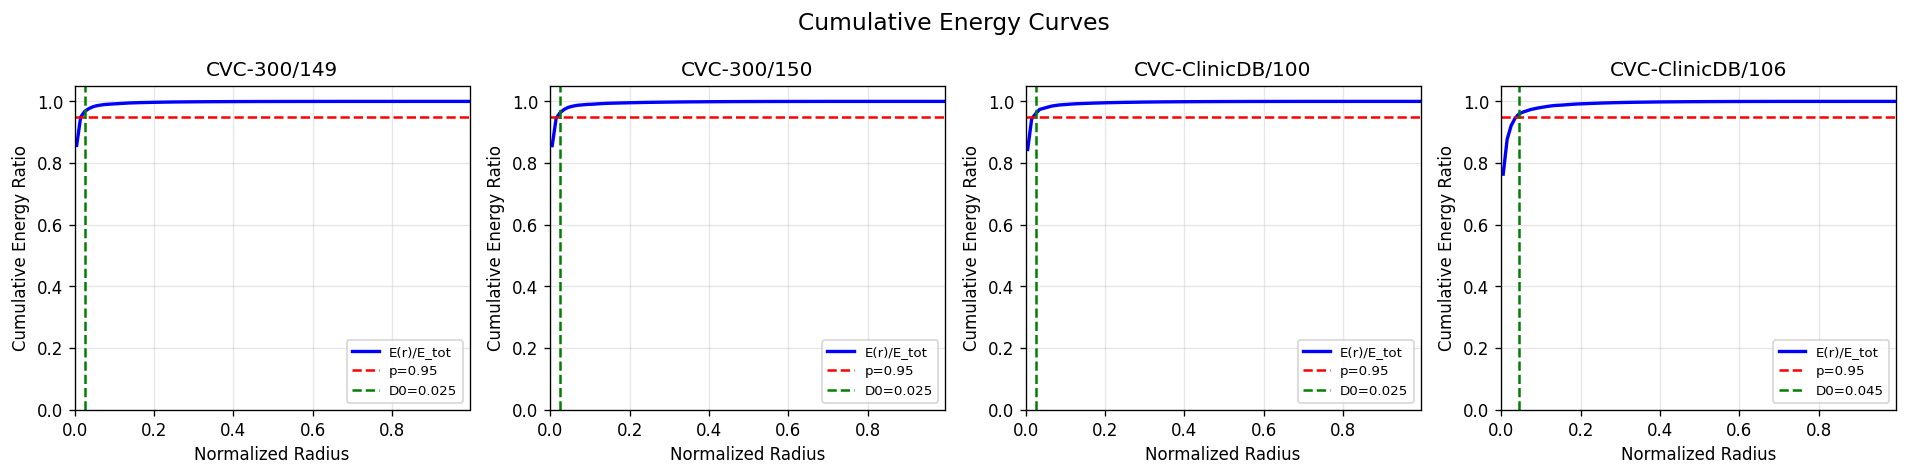

In [6]:
# Plot energy curves E(r)/E_tot vs r
fig, axes = plt.subplots(1, min(4, n_samples), figsize=(4 * min(4, n_samples), 4))
if n_samples == 1:
    axes = [axes]

for i in range(min(4, n_samples)):
    radii = diag_info['radii'][i].numpy()
    cum_energy = diag_info['cumulative_energy'][i].numpy()
    d0 = diag_info['d0_radii'][i].item()
    
    axes[i].plot(radii, cum_energy, 'b-', linewidth=2, label='E(r)/E_tot')
    axes[i].axhline(y=fft_cfg.p_default, color='r', linestyle='--', label=f'p={fft_cfg.p_default}')
    axes[i].axvline(x=d0, color='g', linestyle='--', label=f'D0={d0:.3f}')
    axes[i].set_xlabel('Normalized Radius')
    axes[i].set_ylabel('Cumulative Energy Ratio')
    axes[i].set_title(f'{sample_names[i]}')
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim([0, radii.max()])
    axes[i].set_ylim([0, 1.05])

plt.suptitle('Cumulative Energy Curves', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'energy_curves.png')
plt.show()


## 3. Stage 2 Edge Alignment Diagnostics (Goal D2)

Compute Edge Alignment score using GT boundary band:

$$EA = \frac{\sum_{(x,y) \in \partial M} ||\nabla I_{high}(x,y)||}{\sum_{(x,y)} ||\nabla I_{high}(x,y)||}$$

Stratify by polyp size buckets (small/medium/large) and show distributions.


In [7]:
from skimage.morphology import binary_dilation, binary_erosion, disk

def compute_boundary_band(mask: np.ndarray, r: int = 3) -> np.ndarray:
    """Compute boundary band of mask."""
    mask_bin = mask > 0.5
    dilated = binary_dilation(mask_bin, disk(r))
    eroded = binary_erosion(mask_bin, disk(r))
    boundary = dilated & (~eroded)
    return boundary.astype(np.float32)

def compute_edge_alignment(i_high: torch.Tensor, mask: torch.Tensor, r: int = 3) -> float:
    """Compute Edge Alignment score.
    
    EA = sum(||grad_high|| at boundary) / sum(||grad_high|| everywhere)
    """
    grad_high = compute_gradient_magnitude(i_high)
    grad_np = grad_high.squeeze().numpy()
    mask_np = mask.squeeze().numpy()
    
    boundary = compute_boundary_band(mask_np, r)
    
    grad_at_boundary = (grad_np * boundary).sum()
    grad_total = grad_np.sum() + 1e-8
    
    return float(grad_at_boundary / grad_total)

def get_polyp_size_bucket(mask: np.ndarray) -> str:
    """Categorize polyp size."""
    area_ratio = (mask > 0.5).mean()
    if area_ratio < 0.02:
        return 'small'
    elif area_ratio < 0.1:
        return 'medium'
    else:
        return 'large'


In [8]:
# Compute Edge Alignment for all samples
ea_results = []

for i in range(len(images)):
    ea = compute_edge_alignment(fft_out.i_high[i:i+1], masks[i:i+1])
    size_bucket = get_polyp_size_bucket(masks[i].numpy())
    area = float((masks[i] > 0.5).float().mean())
    
    ea_results.append({
        'name': sample_names[i],
        'edge_alignment': ea,
        'size_bucket': size_bucket,
        'polyp_area': area,
    })

ea_df = pd.DataFrame(ea_results)
display(ea_df)


name  edge_alignment size_bucket  polyp_area
0                       CVC-300/149        0.051096      medium    0.096375
1                       CVC-300/150        0.041961      medium    0.071808
2                  CVC-ClinicDB/100        0.019673      medium    0.065063
3                  CVC-ClinicDB/106        0.078989       large    0.130142
4  Kvasir/cju0u82z3cuma0835wlxrnrjv        0.063944       large    0.246979
5  Kvasir/cju15wdt3zla10801odjiw7sy        0.050780       large    0.163452
6               ETIS-LaribPolypDB/1        0.012316       small    0.008850
7              ETIS-LaribPolypDB/10        0.009045       small    0.008621

/var/folders/yb/pzn7_4ss723387wz1s_n70qh0000gn/T/ipykernel_19465/3794410764.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(buckets, labels=labels)


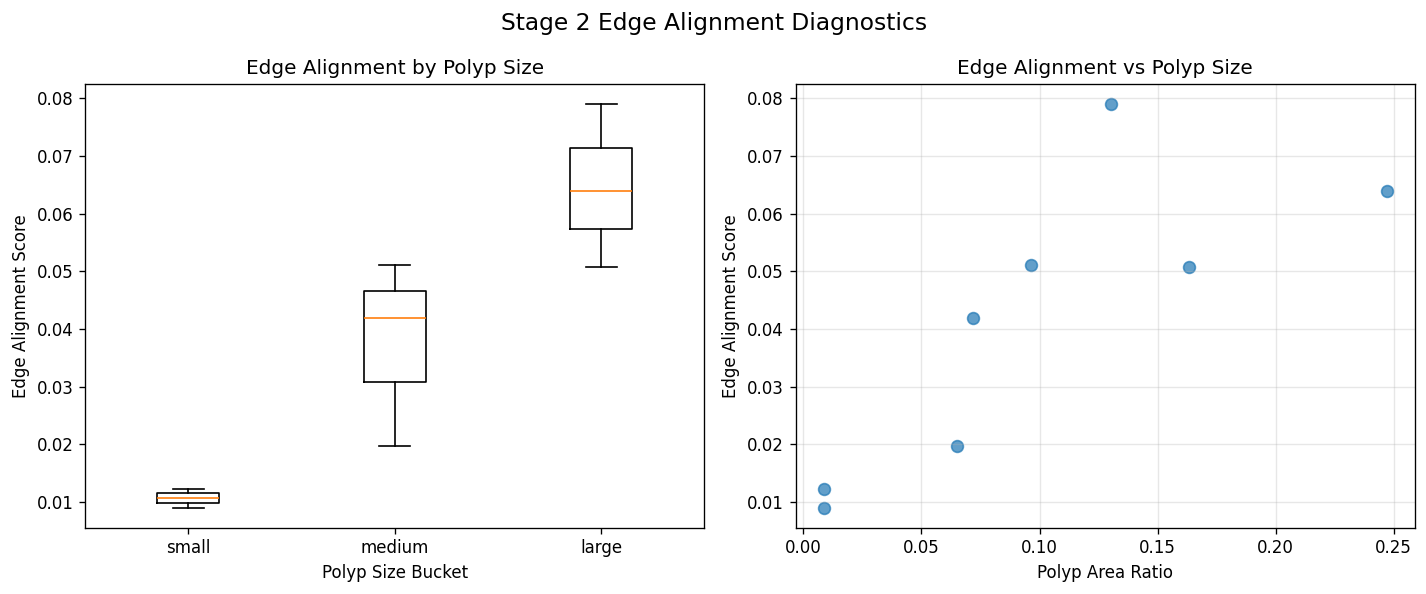


Edge Alignment Summary:
             count      mean       std       min       25%       50%  \
size_bucket                                                            
large          3.0  0.064571  0.014115  0.050780  0.057362  0.063944   
medium         3.0  0.037577  0.016164  0.019673  0.030817  0.041961   
small          2.0  0.010680  0.002313  0.009045  0.009863  0.010680   

                  75%       max  
size_bucket                      
large        0.071466  0.078989  
medium       0.046528  0.051096  
small        0.011498  0.012316  


In [9]:
# Plot Edge Alignment distribution by polyp size
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot by size bucket
if len(ea_df) > 2:
    size_order = ['small', 'medium', 'large']
    buckets = [ea_df[ea_df['size_bucket'] == s]['edge_alignment'].values for s in size_order if s in ea_df['size_bucket'].values]
    labels = [s for s in size_order if s in ea_df['size_bucket'].values]
    
    if buckets:
        axes[0].boxplot(buckets, labels=labels)
        axes[0].set_xlabel('Polyp Size Bucket')
        axes[0].set_ylabel('Edge Alignment Score')
        axes[0].set_title('Edge Alignment by Polyp Size')

# Scatter plot: EA vs polyp area
axes[1].scatter(ea_df['polyp_area'], ea_df['edge_alignment'], s=50, alpha=0.7)
axes[1].set_xlabel('Polyp Area Ratio')
axes[1].set_ylabel('Edge Alignment Score')
axes[1].set_title('Edge Alignment vs Polyp Size')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Stage 2 Edge Alignment Diagnostics', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'edge_alignment_diagnostics.png')
plt.show()

print(f"\nEdge Alignment Summary:")
print(ea_df.groupby('size_bucket')['edge_alignment'].describe())


## 4. Stage 3 Fusion Interpretability (Goal D3)

- Visualize π_H, π_L heatmaps
- Compare to correctness maps of each branch
- Compute gating correctness correlation


In [10]:
# Simulate branch outputs (in real usage, load from model)
# For demo, create synthetic alpha and evidence

def create_mock_branch_outputs(images: torch.Tensor, masks: torch.Tensor):
    """Create mock branch outputs for demonstration.
    
    In real usage, these would come from the DUET model.
    """
    b, c, h, w = images.shape
    
    # Evidence (positive, from softplus)
    # High-freq branch: better at detecting edges
    grad = compute_gradient_magnitude(images)
    e_h_polyp = 2.0 + 5.0 * grad.squeeze(1)  # Higher evidence where edges are
    e_h_bg = 3.0 - 0.5 * grad.squeeze(1)
    e_h = torch.stack([e_h_bg, e_h_polyp], dim=1).clamp(0.1)
    
    # Low-freq branch: better at detecting large regions
    blurred_mask = F.avg_pool2d(masks, kernel_size=15, stride=1, padding=7)
    e_l_polyp = 2.0 + 4.0 * blurred_mask.squeeze(1)
    e_l_bg = 3.0 - blurred_mask.squeeze(1)
    e_l = torch.stack([e_l_bg, e_l_polyp], dim=1).clamp(0.1)
    
    # Add some noise
    e_h = e_h + torch.randn_like(e_h) * 0.3
    e_l = e_l + torch.randn_like(e_l) * 0.3
    e_h = e_h.clamp(0.1)
    e_l = e_l.clamp(0.1)
    
    alpha_h = e_h + 1.0
    alpha_l = e_l + 1.0
    
    return alpha_h, e_h, alpha_l, e_l

alpha_h, e_h, alpha_l, e_l = create_mock_branch_outputs(images, masks)
print(f'Alpha H shape: {alpha_h.shape}')
print(f'Alpha L shape: {alpha_l.shape}')


Alpha H shape: torch.Size([8, 2, 256, 256])
Alpha L shape: torch.Size([8, 2, 256, 256])


In [11]:
# Run evidence fusion
fusion_cfg = EvidenceFusionV2Config(
    detach_weights=True,
    fusion_type='evidence_weighted'
)
fusion = EvidenceFusionV2(fusion_cfg)

with torch.no_grad():
    alpha_f, p_f, u_f, (pi_h, pi_l) = fusion(
        alpha_h, e_h, alpha_l, e_l, return_weights=True
    )

print(f'Fused probability shape: {p_f.shape}')
print(f'Mean π_H: {pi_h.mean():.3f}, Mean π_L: {pi_l.mean():.3f}')


Fused probability shape: torch.Size([8, 1, 256, 256])
Mean π_H: 0.509, Mean π_L: 0.491


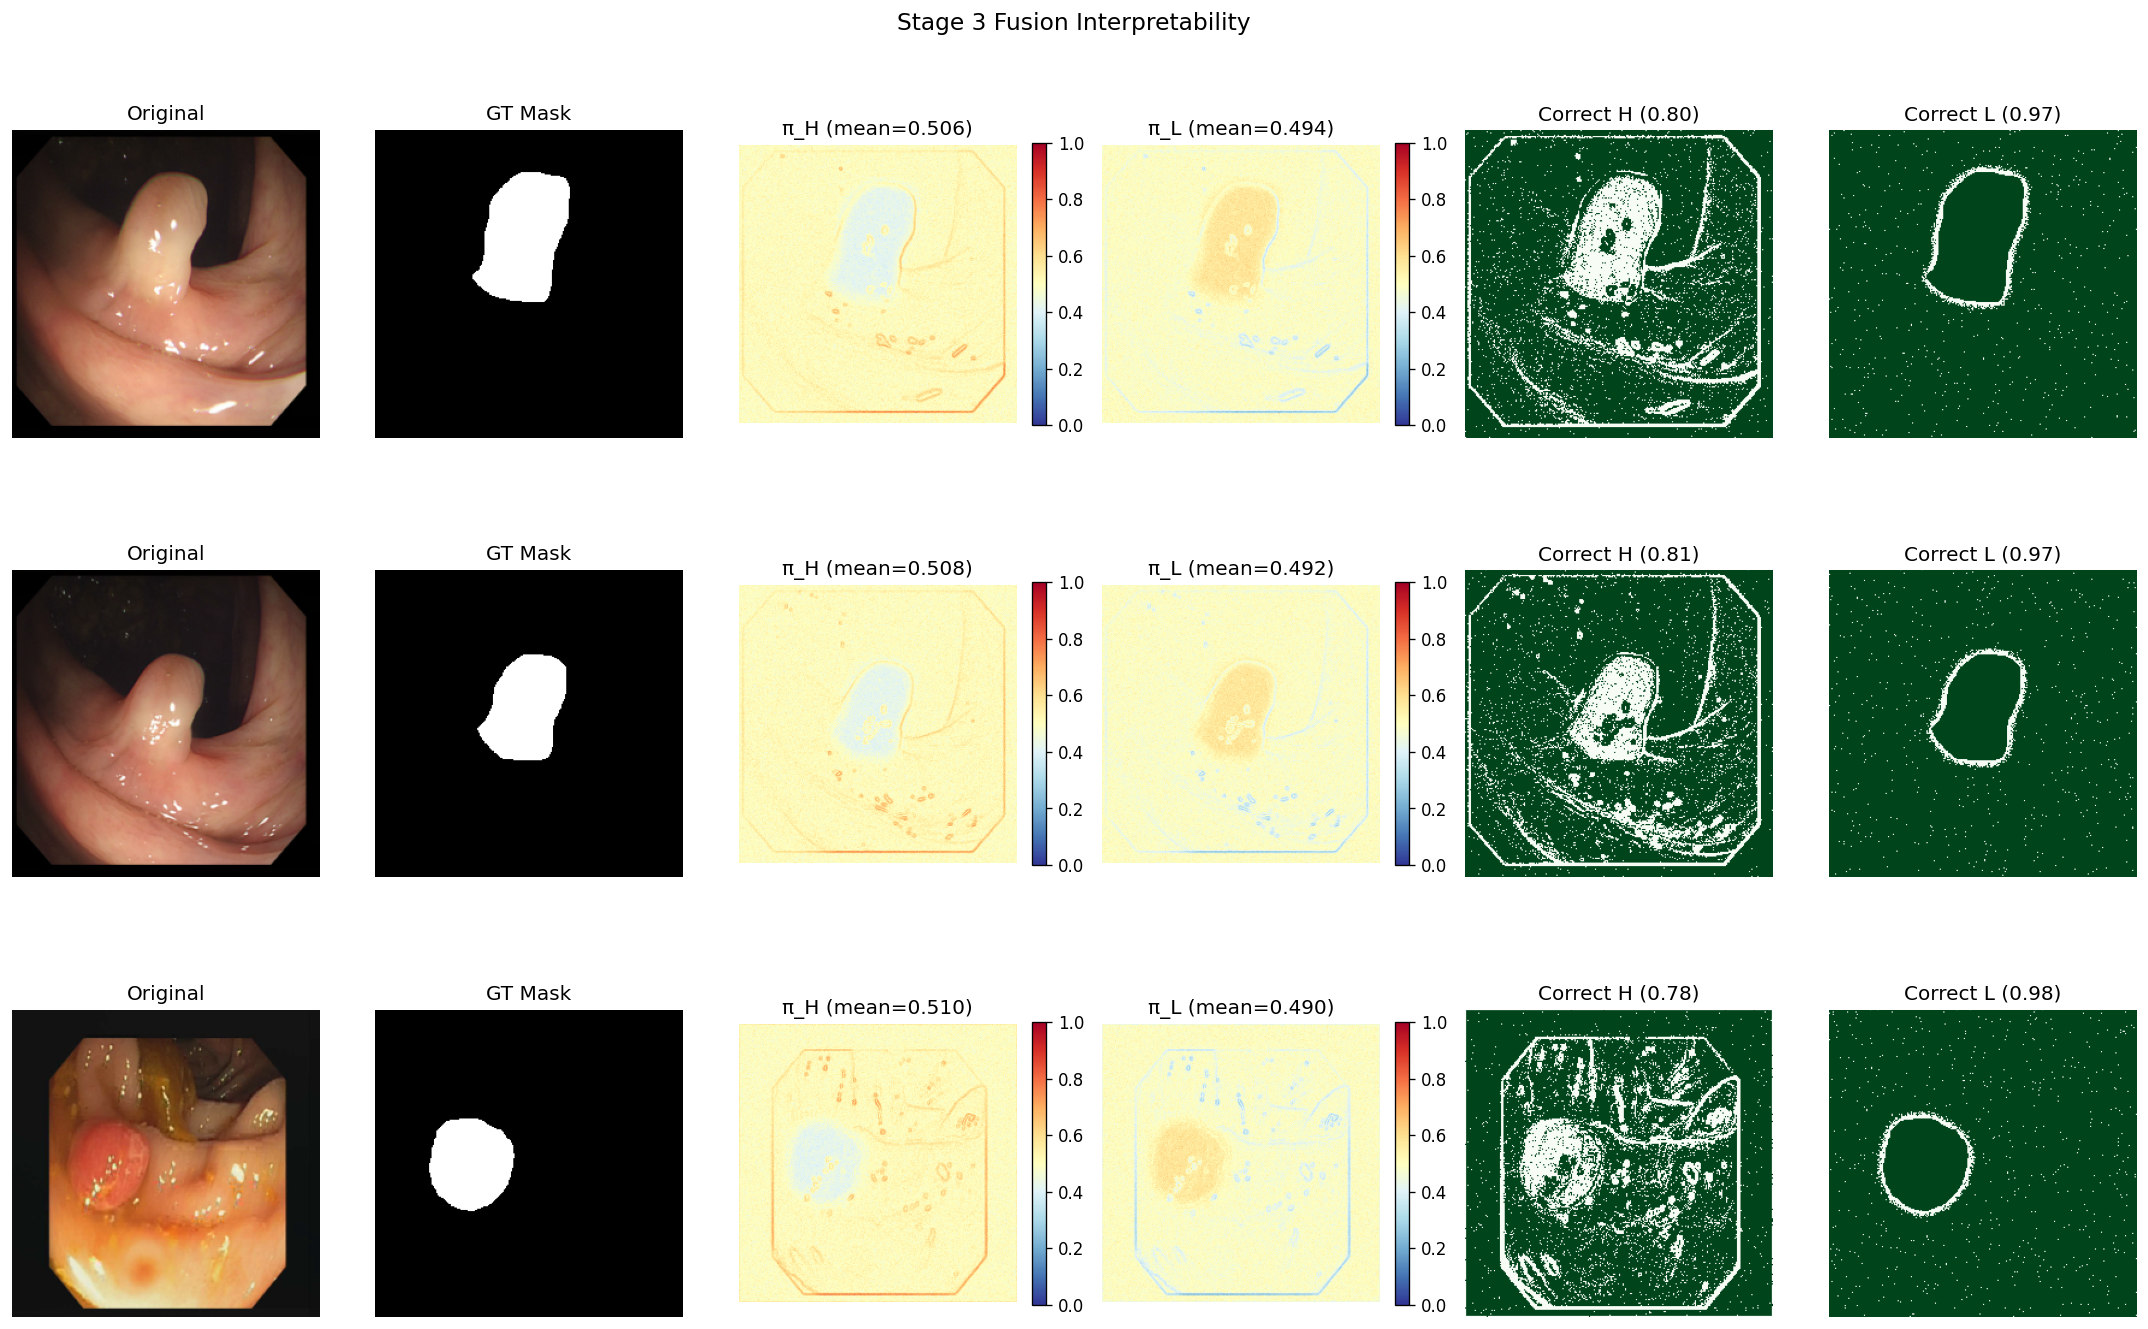

In [12]:
# Visualize fusion weights
from src.models.fusion.evidence_fusion_v2 import dirichlet_mean_binary

p_h = dirichlet_mean_binary(alpha_h)
p_l = dirichlet_mean_binary(alpha_l)

# Compute correctness maps
correct_h, correct_l = fusion.compute_branch_correctness(p_h, p_l, masks, threshold=0.5)

n_show = min(3, len(images))
fig, axes = plt.subplots(n_show, 6, figsize=(18, 4 * n_show))
if n_show == 1:
    axes = axes.reshape(1, -1)

for i in range(n_show):
    # Original
    axes[i, 0].imshow(normalize_for_display(tensor_to_numpy(images[i:i+1])[0]))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    # GT mask
    axes[i, 1].imshow(masks[i, 0].numpy(), cmap='gray')
    axes[i, 1].set_title('GT Mask')
    axes[i, 1].axis('off')
    
    # π_H heatmap
    im_h = axes[i, 2].imshow(pi_h[i, 0].numpy(), cmap='RdYlBu_r', vmin=0, vmax=1)
    axes[i, 2].set_title(f'π_H (mean={pi_h[i].mean():.3f})')
    axes[i, 2].axis('off')
    plt.colorbar(im_h, ax=axes[i, 2], fraction=0.046)
    
    # π_L heatmap  
    im_l = axes[i, 3].imshow(pi_l[i, 0].numpy(), cmap='RdYlBu_r', vmin=0, vmax=1)
    axes[i, 3].set_title(f'π_L (mean={pi_l[i].mean():.3f})')
    axes[i, 3].axis('off')
    plt.colorbar(im_l, ax=axes[i, 3], fraction=0.046)
    
    # Correctness H
    axes[i, 4].imshow(correct_h[i, 0].numpy(), cmap='Greens', vmin=0, vmax=1)
    axes[i, 4].set_title(f'Correct H ({correct_h[i].mean():.2f})')
    axes[i, 4].axis('off')
    
    # Correctness L
    axes[i, 5].imshow(correct_l[i, 0].numpy(), cmap='Greens', vmin=0, vmax=1)
    axes[i, 5].set_title(f'Correct L ({correct_l[i].mean():.2f})')
    axes[i, 5].axis('off')

plt.suptitle('Stage 3 Fusion Interpretability', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fusion_interpretability.png')
plt.show()


In [13]:
# Compute gating correctness correlation
def compute_correlation(x: torch.Tensor, y: torch.Tensor) -> float:
    """Compute Pearson correlation between flattened tensors."""
    x_flat = x.flatten().numpy()
    y_flat = y.flatten().numpy()
    return float(np.corrcoef(x_flat, y_flat)[0, 1])

corr_h = compute_correlation(pi_h, correct_h)
corr_l = compute_correlation(pi_l, correct_l)

print(f"Gating Correctness Correlation:")
print(f"  corr(π_H, correct_H) = {corr_h:.4f}")
print(f"  corr(π_L, correct_L) = {corr_l:.4f}")
print()
print("Interpretation:")
print("  Positive correlation means fusion weights correctly assign")
print("  higher weight to the better-performing branch.")


Gating Correctness Correlation:
  corr(π_H, correct_H) = -0.1347
  corr(π_L, correct_L) = -0.0240

Interpretation:
  Positive correlation means fusion weights correctly assign
  higher weight to the better-performing branch.


## 5. Uncertainty-as-Error Detector (Goal D4)

- Define pixel error mask E = 1[pred != GT]
- Compute AUROC/AUPR of uncertainty U vs E
- Risk-coverage curve: reject top-q% highest uncertainty pixels and plot Dice vs coverage


In [14]:
# Compute error masks
pred_binary = (p_f > 0.5).float()
error_mask = (pred_binary != masks).float()

# Flatten for AUROC/AUPR computation
uncertainty_flat = u_f.flatten().numpy()
error_flat = error_mask.flatten().numpy()

# Compute metrics
if error_flat.sum() > 0 and error_flat.sum() < len(error_flat):
    auroc = roc_auc_score(error_flat, uncertainty_flat)
    aupr = average_precision_score(error_flat, uncertainty_flat)
    print(f"Uncertainty-as-Error Detection:")
    print(f"  AUROC: {auroc:.4f}")
    print(f"  AUPR: {aupr:.4f}")
else:
    auroc, aupr = 0.5, 0.5
    print("Warning: Cannot compute AUROC/AUPR (all same label)")


Uncertainty-as-Error Detection:
  AUROC: 0.1341
  AUPR: 0.0469


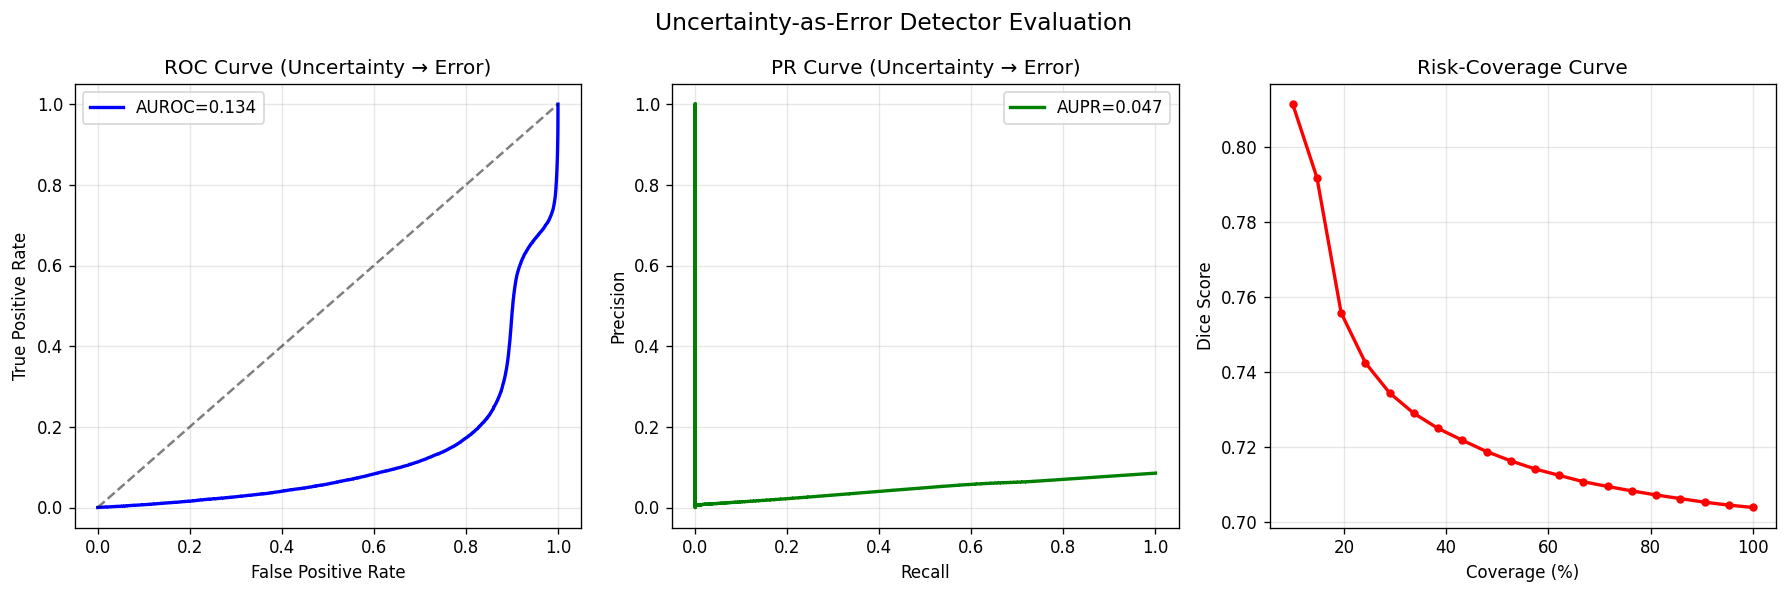

In [15]:
# Plot ROC and PR curves
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

if error_flat.sum() > 0 and error_flat.sum() < len(error_flat):
    # ROC curve
    fpr, tpr, _ = roc_curve(error_flat, uncertainty_flat)
    axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUROC={auroc:.3f}')
    axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve (Uncertainty → Error)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # PR curve
    precision, recall, _ = precision_recall_curve(error_flat, uncertainty_flat)
    axes[1].plot(recall, precision, 'g-', linewidth=2, label=f'AUPR={aupr:.3f}')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('PR Curve (Uncertainty → Error)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

# Risk-coverage curve
def compute_dice(pred: np.ndarray, gt: np.ndarray) -> float:
    intersection = (pred * gt).sum()
    return float(2 * intersection / (pred.sum() + gt.sum() + 1e-8))

# Sort by uncertainty and compute Dice at different coverage levels
n_pixels = len(uncertainty_flat)
sort_idx = np.argsort(uncertainty_flat)  # Low uncertainty first

coverages = np.linspace(0.1, 1.0, 20)
dices = []

pred_flat = pred_binary.flatten().numpy()
gt_flat = masks.flatten().numpy()

for cov in coverages:
    n_keep = int(cov * n_pixels)
    keep_idx = sort_idx[:n_keep]
    
    # Create masked predictions
    pred_masked = pred_flat.copy()
    gt_masked = gt_flat.copy()
    
    # Only evaluate on kept pixels
    mask_keep = np.zeros_like(pred_flat)
    mask_keep[keep_idx] = 1
    
    dice = compute_dice(pred_flat * mask_keep, gt_flat * mask_keep)
    dices.append(dice)

axes[2].plot(coverages * 100, dices, 'r-', linewidth=2, marker='o', markersize=4)
axes[2].set_xlabel('Coverage (%)')
axes[2].set_ylabel('Dice Score')
axes[2].set_title('Risk-Coverage Curve')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Uncertainty-as-Error Detector Evaluation', fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'uncertainty_error_detection.png')
plt.show()


## 6. Stage 1 Diagnostics (Optional)

If Stage 1 encoder checkpoints exist:
- Domain classifier probe: train linear classifier on frozen features to predict domain
- Boundary probe: train linear probe to classify boundary vs non-boundary pixels

**Note**: This section requires a trained Stage 1 encoder. If not available, we demonstrate the probe methodology with synthetic features.


In [16]:
# Check for Stage 1 checkpoint
STAGE1_CKPT = Path('../runs/stage1/checkpoints/stage1_best.pt')

if STAGE1_CKPT.exists():
    print(f'Found Stage 1 checkpoint: {STAGE1_CKPT}')
    # Load encoder and extract features
    # This would require the actual model loading code
    USE_REAL_FEATURES = True
else:
    print('Stage 1 checkpoint not found. Using synthetic features for demo.')
    USE_REAL_FEATURES = False


Stage 1 checkpoint not found. Using synthetic features for demo.


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def domain_classifier_probe(features: np.ndarray, domains: np.ndarray) -> dict:
    """Train domain classifier probe on frozen features.
    
    Lower accuracy = better domain invariance.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        features, domains, test_size=0.3, random_state=SEED, stratify=domains
    )
    
    clf = LogisticRegression(max_iter=1000, random_state=SEED)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    return {
        'accuracy': acc,
        'chance_level': 1.0 / len(np.unique(domains)),
        'n_domains': len(np.unique(domains)),
    }

def boundary_probe(features: np.ndarray, boundary_labels: np.ndarray) -> dict:
    """Train boundary classifier probe on frozen features.
    
    Higher AUC/F1 = better boundary awareness.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        features, boundary_labels, test_size=0.3, random_state=SEED
    )
    
    clf = LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    return {
        'auc': roc_auc_score(y_test, y_prob),
        'f1': f1_score(y_test, y_pred),
        'accuracy': accuracy_score(y_test, y_pred),
    }


In [18]:
# Demo with synthetic features
if not USE_REAL_FEATURES:
    print("Creating synthetic features for probe demonstration...")
    
    n_samples = 1000
    feat_dim = 128
    n_domains = 3
    
    # Synthetic features with some domain structure
    features = np.random.randn(n_samples, feat_dim)
    domains = np.random.randint(0, n_domains, n_samples)
    
    # Add domain-specific bias (simulating imperfect invariance)
    for d in range(n_domains):
        mask = domains == d
        features[mask, :10] += d * 0.5
    
    # Synthetic boundary labels
    boundary_labels = (np.random.rand(n_samples) > 0.8).astype(int)
    # Features slightly correlated with boundary
    features[boundary_labels == 1, 10:20] += 0.3
    
    # Run probes
    domain_results = domain_classifier_probe(features, domains)
    boundary_results = boundary_probe(features, boundary_labels)
    
    print("\n=== Domain Classifier Probe ===")
    print(f"  Accuracy: {domain_results['accuracy']:.3f}")
    print(f"  Chance level: {domain_results['chance_level']:.3f}")
    print(f"  n_domains: {domain_results['n_domains']}")
    print(f"  → {'GOOD' if domain_results['accuracy'] < 0.5 else 'BAD'} domain invariance")
    
    print("\n=== Boundary Probe ===")
    print(f"  AUC: {boundary_results['auc']:.3f}")
    print(f"  F1: {boundary_results['f1']:.3f}")
    print(f"  → {'GOOD' if boundary_results['auc'] > 0.6 else 'BAD'} boundary awareness")


Creating synthetic features for probe demonstration...

=== Domain Classifier Probe ===
  Accuracy: 0.590
  Chance level: 0.333
  n_domains: 3
  → BAD domain invariance

=== Boundary Probe ===
  AUC: 0.735
  F1: 0.516
  → GOOD boundary awareness


## 7. Summary and Export

Save all diagnostic results to a summary file.


In [19]:
# Compile summary
summary = {
    'timestamp': TIMESTAMP,
    'n_samples': len(images),
    'fft_config': {
        'p_default': fft_cfg.p_default,
        'method': 'energy_percentile',
    },
    'fft_results': {
        'd0_mean': float(fft_out.d0_radii.mean()),
        'd0_std': float(fft_out.d0_radii.std()),
    },
    'edge_alignment': {
        'mean': float(ea_df['edge_alignment'].mean()),
        'std': float(ea_df['edge_alignment'].std()),
    },
    'fusion': {
        'pi_h_mean': float(pi_h.mean()),
        'pi_l_mean': float(pi_l.mean()),
        'corr_h': corr_h,
        'corr_l': corr_l,
    },
    'uncertainty': {
        'auroc': auroc,
        'aupr': aupr,
    },
}

# Save summary as JSON
import json
with open(OUTPUT_DIR / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

# Save Edge Alignment results
ea_df.to_csv(OUTPUT_DIR / 'edge_alignment_results.csv', index=False)

print(f"\n{'='*60}")
print("DUET DIAGNOSTICS SUMMARY")
print(f"{'='*60}")
print(f"Output directory: {OUTPUT_DIR.absolute()}")
print(f"\nFiles saved:")
for f in sorted(OUTPUT_DIR.glob('*')):
    print(f"  - {f.name}")
print(f"\nKey Metrics:")
print(f"  FFT D0: {summary['fft_results']['d0_mean']:.3f} ± {summary['fft_results']['d0_std']:.3f}")
print(f"  Edge Alignment: {summary['edge_alignment']['mean']:.3f} ± {summary['edge_alignment']['std']:.3f}")
print(f"  Fusion π_H/π_L: {summary['fusion']['pi_h_mean']:.3f} / {summary['fusion']['pi_l_mean']:.3f}")
print(f"  Uncertainty AUROC: {summary['uncertainty']['auroc']:.3f}")
print(f"{'='*60}")



DUET DIAGNOSTICS SUMMARY
Output directory: /Users/minhnguyen/Desktop/DUET/notebooks/../outputs/diagnostics/20260108_233017

Files saved:
  - edge_alignment_diagnostics.png
  - edge_alignment_results.csv
  - energy_curves.png
  - fft_split_visualization.png
  - fusion_interpretability.png
  - summary.json
  - uncertainty_error_detection.png

Key Metrics:
  FFT D0: 0.024 ± 0.010
  Edge Alignment: 0.041 ± 0.025
  Fusion π_H/π_L: 0.509 / 0.491
  Uncertainty AUROC: 0.134
